In [10]:
"""Backend supported: pytorch, paddle, jax

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""

import deepxde as dde
import numpy as np
import time
import os

n_iter = 10000
log_every = 25*2
available_time = False# 2*5 #minutes
log_output_fields = {0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}
net_type = ["spinn", "pfnn"][0]
optimizers = ["adam", "LBFGS"][0]

if net_type == "spinn":
    dde.config.set_default_autodiff("forward")

lmbd = 1.0
mu = 0.5
Q = 4.0

lmbd_trainable = dde.Variable(0.8)
mu_trainable = dde.Variable(0.2)

sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack
pi = dde.backend.as_tensor(np.pi)

if dde.backend.backend_name == "jax":
    import jax.numpy as jnp

geom = dde.geometry.Rectangle([0, 0], [1, 1])


# Exact solutions
def func(x):
    if net_type == "spinn":
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
        x = stack(x_mesh, axis=-1)

    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))


def HardBC(x, f):
    if net_type == "spinn":
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
        x = stack(x_mesh, axis=-1)

    Ux = f[:, 0] * x[:, 1] * (1 - x[:, 1])
    Uy = f[:, 1] * x[:, 0] * (1 - x[:, 0]) * x[:, 1]

    Sxx = f[:, 2] * x[:, 0] * (1 - x[:, 0])
    Syy = f[:, 3] * (1 - x[:, 1]) + (lmbd + 2 * mu) * Q * sin(pi * x[:, 0])
    Sxy = f[:, 4]
    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)


def fx(x):
    return (
        -lmbd
        * (
            4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - mu
        * (
            np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
    )


def fy(x):
    return (
        lmbd
        * (
            3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
            - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
        )
        - mu
        * (
            2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
            + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4
        )
        + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
    )


def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[
            0
        ]  # second element is the function used by jax to compute the gradients
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)


def pde(x, f):
    # x_mesh = jnp.meshgrid(x[:,0].ravel(), x[:,0].ravel(), indexing='ij')
    if net_type == "spinn":
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
        x = stack(x_mesh, axis=1)

    E_xx = jacobian(f, x, i=0, j=0)
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu_trainable + lmbd_trainable) + E_yy * lmbd_trainable
    S_yy = E_yy * (2 * mu_trainable + lmbd_trainable) + E_xx * lmbd_trainable
    S_xy = E_xy * 2 * mu_trainable

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y - fx(x)
    momentum_y = Sxy_x + Syy_y - fy(x)

    if dde.backend.backend_name == "jax":
        f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]


num_boundary = 0
bcs = []

Set the default automatic differentiation to forward mode.


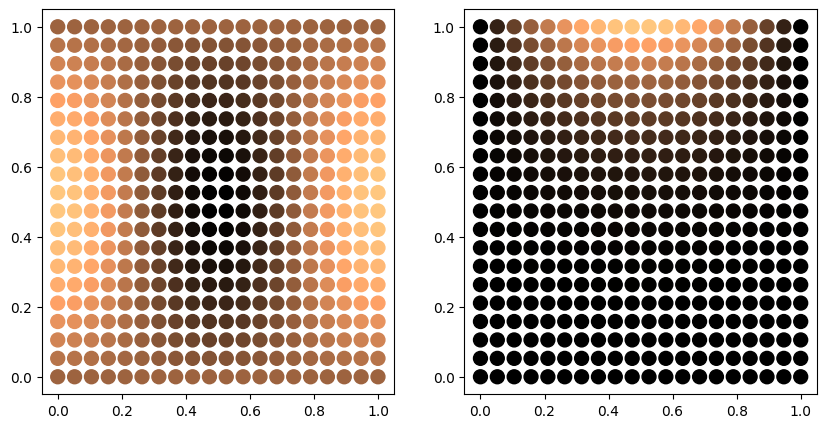

In [2]:
import matplotlib.pyplot as plt

n_DIC = 20
# n_DIC = 20

# X_DIC = geom.uniform_points(1000, boundary=False)
X_DIC_input = np.stack([np.linspace(0, 1, n_DIC)] * 2, axis=1)
X_DIC_mesh = [x_.ravel() for x_ in np.meshgrid(X_DIC_input[:,0],X_DIC_input[:,1],indexing="ij")]
X_DIC_plot = stack(X_DIC_mesh, axis=1)
if net_type != "spinn":
    X_DIC_input = X_DIC_plot
U_DIC = func(X_DIC_input)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X_DIC_plot[:, 0], X_DIC_plot[:, 1], s=100, c=U_DIC[:, 0], cmap="copper")
ax[1].scatter(X_DIC_plot[:, 0], X_DIC_plot[:, 1], s=100, c=U_DIC[:, 1], cmap="copper")
measure_Ux = dde.PointSetBC(X_DIC_input, U_DIC[:, 0:1], component=0)
measure_Uy = dde.PointSetBC(X_DIC_input, U_DIC[:, 1:2], component=1)

# measure_Ux = dde.PointSetOperatorBC(X_DIC_input, U_DIC[:, 0:1], lambda inputs,outputs,X: outputs[:,0:1])
# measure_Uy = dde.PointSetOperatorBC(X_DIC_input, U_DIC[:, 1:2], lambda inputs,outputs,X: outputs[:,1:2])

# bcs = []

In [3]:

activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
if net_type == "spinn":
    layers = [32, 32, 32, 32, 5]
    net = dde.nn.SPINN(layers, activation, initializer)
    num_point = 64
    total_points = num_point**2 + num_boundary**2
    X_plot = np.stack([np.linspace(0, 1, 100)] * 2, axis=1)

else:
    layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
    net = dde.nn.PFNN(layers, activation, initializer)
    num_point = 500
    total_points = num_point + num_boundary
    X_mesh = np.meshgrid(
        np.linspace(0, 1, 100, dtype=np.float32),
        np.linspace(0, 1, 100, dtype=np.float32),
        indexing="ij",
    )
    X_plot = np.stack((X_mesh[0].ravel(), X_mesh[1].ravel()), axis=1)

net.apply_output_transform(HardBC)

In [4]:
bcs = []
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_point,
    # num_boundary=num_boundary,
    solution=func,
    num_test=num_point,
    is_SPINN=net_type == "spinn",
)
model = dde.Model(data, net)
# loss_weights = [1,1,1,1,1]

model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])#, loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=1000, display_every=300)

/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred t

Compiling model...
'compile' took 0.978081 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.81e+03, 2.57e+02, 2.12e-03, 3.14e+01, 1.41e-03]    [1.75e+03, 2.56e+02, 2.42e-03, 3.53e+01, 9.63e-04]    [1.14e+00]    
300       [8.75e+00, 6.80e+00, 1.38e+00, 1.38e+00, 1.44e+00]    [5.54e+00, 3.37e+00, 8.71e-01, 8.63e-01, 1.30e+00]    [2.61e-01]    
600       [2.32e+00, 8.76e-01, 4.33e-01, 4.54e-01, 2.67e-01]    [1.79e+00, 5.58e-01, 1.81e-01, 1.85e-01, 1.31e-01]    [1.08e-01]    
900       [1.18e+00, 3.22e-01, 2.40e-01, 2.05e-01, 1.26e-01]    [1.03e+00, 2.95e-01, 1.93e-01, 9.77e-02, 7.34e-02]    [7.44e-02]    
1000      [9.41e-01, 2.34e-01, 1.93e-01, 1.53e-01, 1.03e-01]    [8.24e-01, 1.94e-01, 1.55e-01, 7.59e-02, 5.80e-02]    [6.66e-02]    

Best model at step 1000:
  train loss: 1.62e+00
  test loss: 1.31e+00
  test metric: [6.66e-02]

'train' took 11.194796 s



In [9]:
bcs = [measure_Ux, measure_Uy]
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_point,
    num_boundary=num_boundary,
    solution=func,
    num_test=num_point,
    is_SPINN=net_type == "spinn",
)
model = dde.Model(data, net)

loss_weights = [1,1,1,1,1,1,1]
trainable_variables = [lmbd_trainable, mu_trainable]

model.compile(optimizer, lr=0.001, metrics=["l2 relative error"], loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=10000, display_every=300)
print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")

model.compile(optimizer, lr=0.001, metrics=["l2 relative error"], external_trainable_variables=trainable_variables, loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=5000, display_every=300)

print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")

/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred t

Compiling model...
'compile' took 0.162011 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric   
0         [1.81e+03, 2.57e+02, 1.73e-03, 3.14e+01, 2.17e-03, 2.49e-01, 5.74e-02]    [1.75e+03, 2.56e+02, 1.98e-03, 3.53e+01, 1.44e-03, 2.49e-01, 5.74e-02]    [1.14e+00]    
300       [8.59e+00, 6.30e+00, 1.07e+00, 1.31e+00, 1.13e+00, 1.28e-02, 1.01e-02]    [5.31e+00, 3.22e+00, 5.78e-01, 7.65e-01, 9.50e-01, 1.28e-02, 1.01e-02]    [2.85e-01]    
600       [2.27e+00, 8.88e-01, 3.75e-01, 4.07e-01, 2.28e-01, 5.21e-03, 3.29e-03]    [1.76e+00, 5.39e-01, 1.73e-01, 1.66e-01, 9.60e-02, 5.21e-03, 3.29e-03]    [1.96e-01]    
900       [1.14e+00, 3.06e-01, 1.91e-01, 2.33e-01, 1.14e-01, 4.14e-03, 3.15e-03]    [9.77e-01, 2.52e-01, 1.54e-01, 9.34e-02, 4.89e-02, 4.14e-03, 3.15e-03]    [1.61e-01]    
1200      [5.88e-01, 1.62e-01, 1.03e-01, 1.25e-01, 5.53e-02, 4.02e-03,

In [6]:
# plotting utilities
def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(domain,model,output_func=None,V_exact=None,plot_diff=False,n_points=10000,fields_name=None):

    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y,indexing="ij")
    Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
    if net_type == "spinn":
        Xinput_model = np.stack((X, Y), axis=1)
    else:
        Xinput_model = Xinput

    plotify = lambda x: x.reshape(Xgrid.shape)

    V_nn = model.predict(Xinput_model)

    if output_func:
        V_nn = output_func(Xinput_model,V_nn)

    V_nn = [plotify(V) for V in V_nn]

    n_fields = len(V_nn) if type(V_nn) is list else 1
    n_plot = 1

    if fields_name is None:
        fields_name = V_exact.__name__.replace('_exact','') if V_exact is not None else 'V'

    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]
    fields_name = [fields_name + coord[i] for i in range(n_fields)]

    if V_exact is not None:
        V_exact = V_exact(Xinput)
        V_exact = [plotify(V) for V in V_exact]
        n_plot = 3 if plot_diff else 2
        
    fig, ax = plt.subplots(n_fields, n_plot, figsize=(4*n_plot, 3*n_fields), dpi=200)

    for i in range(n_fields):
        subax = ax if n_fields == 1 else ax[i] 

        if V_exact is not None:

            cmax = max(V_nn[i].max(), V_exact[i].max())
            cmin = min(V_nn[i].min(), V_exact[i].min())

            im1 = pcolor_plot(subax[0], Xgrid, Ygrid, V_exact[i], f"{fields_name[i]}*", cmin=cmin, cmax=cmax)
            im2 = pcolor_plot(subax[1], Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn", cmin=cmin, cmax=cmax)

            fig.colorbar(im1, ax=subax[1])
        else:
            im1 = pcolor_plot(subax, Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn")
            fig.colorbar(im1, ax=subax)

        if plot_diff:
            diff = V_nn[i] - V_exact[i]
            abs_diff = np.abs(diff)
            cmax = abs_diff.max() if diff.max() > 0 else 0
            cmin = -abs_diff.max() if diff.min() < 0 else 0
            im3 = pcolor_plot(subax[2], Xgrid, Ygrid,diff, f"{fields_name[i]}_nn - {fields_name[i]}*", cmin=cmin, cmax=cmax, colormap="coolwarm")
            fig.colorbar(im3, ax=subax[2])
            subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")

    return fig

<>:74: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
<>:74: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_23184/3850905638.py:74: SyntaxWarning: invalid escape sequence '\m'
  subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")
/tmp/ipykernel_23184/3850905638.py:74: SyntaxWarning: invalid escape sequence '\m'
  subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")


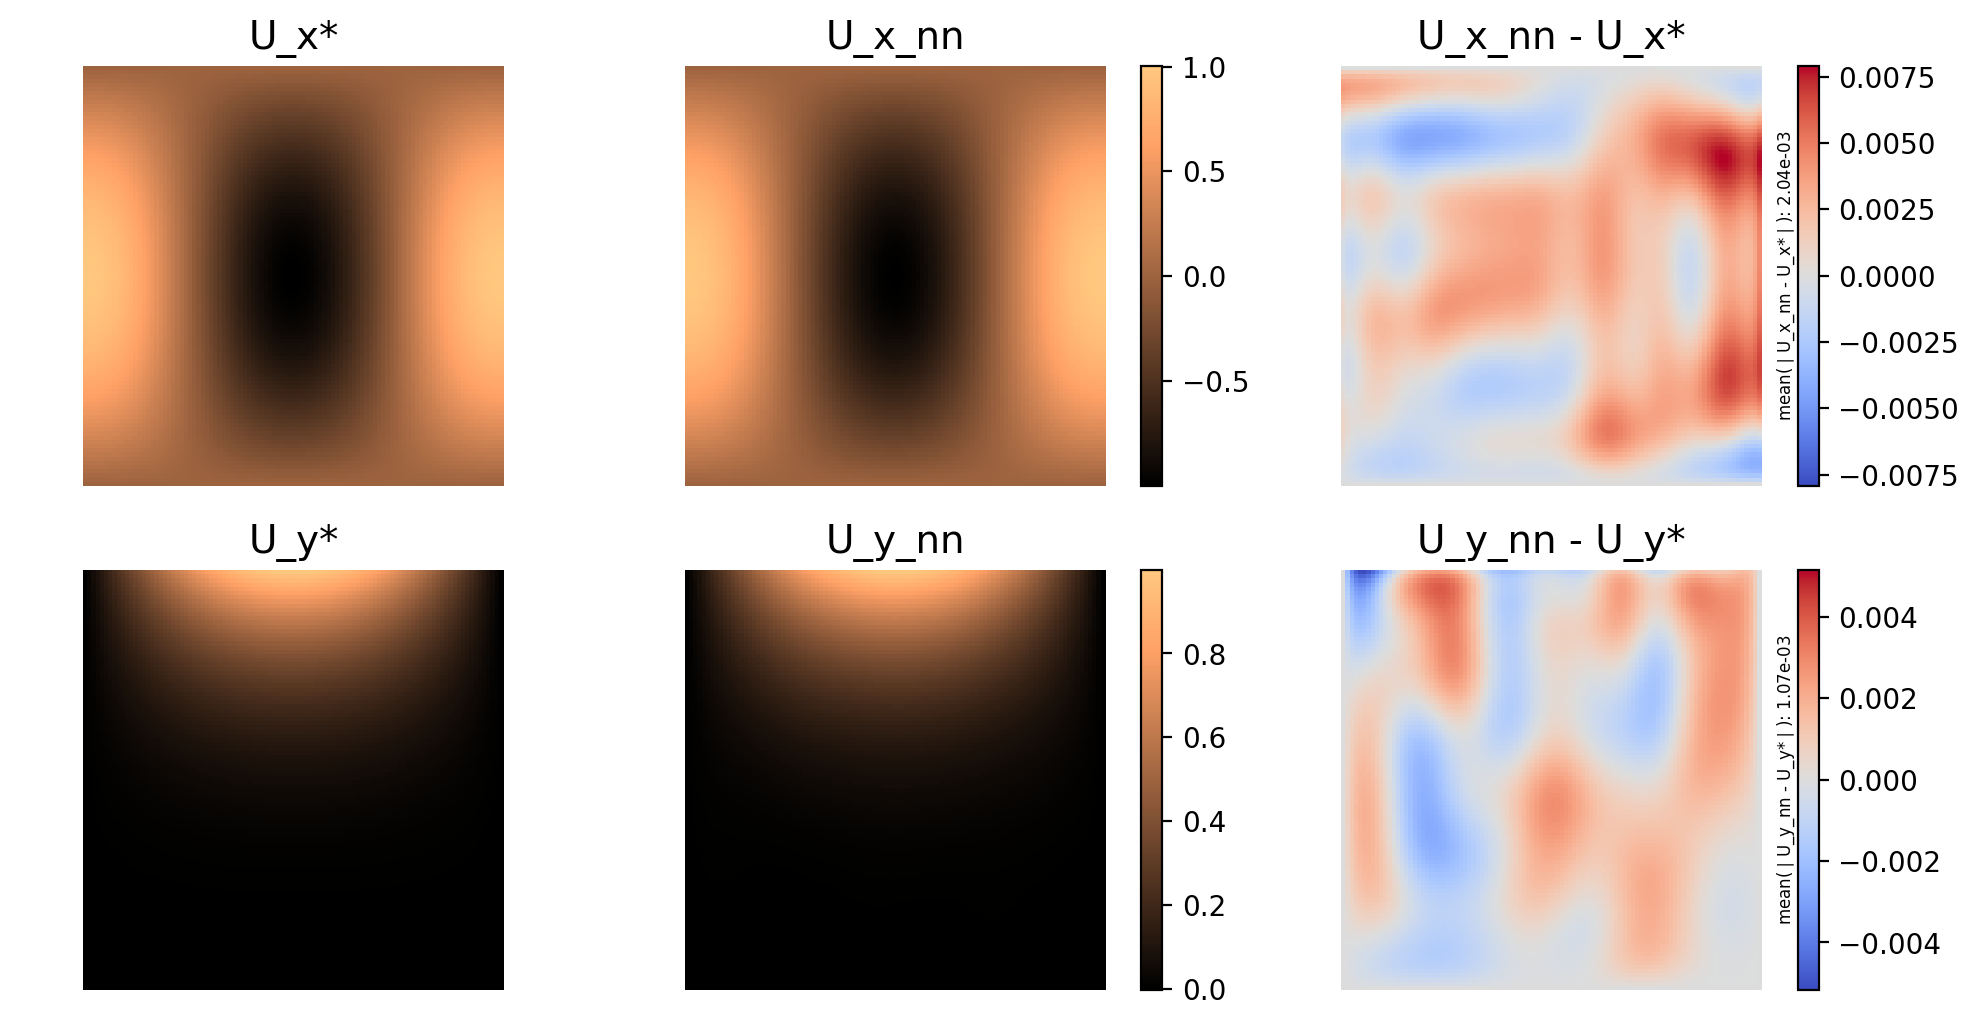

In [7]:
def U_exact(X):
    x, y = X[:,0], X[:,1]
    #displacement U
    Ux = np.cos(2*np.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return np.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1)))

def E_exact(X):
    #strain E
    x, y = X[:,0], X[:,1]
    Exx = -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    Eyy = np.sin(np.pi*x)*Q*y**3
    Exy = 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return (Exx, Eyy, Exy)

def S_exact(X):
    #stress S
    Sxx = (lmbd + 2*mu) * E_exact(X)[0] + lmbd * E_exact(X)[1]
    Syy = (lmbd + 2*mu) * E_exact(X)[1] + lmbd * E_exact(X)[0]
    Sxy = 2*mu*E_exact(X)[2]
    return (Sxx, Syy, Sxy)

def E_nn(X,U):
    """calculate the strain given the displacement"""
    if X.ndim == 1:
        X = X.reshape(1,-1)
        U = U.reshape(1,-1)
    Exx = dde.grad.jacobian(U, X, i=0, j=0)
    Eyy = dde.grad.jacobian(U, X, i=1, j=1)
    Exy = 0.5 * (dde.grad.jacobian(U, X, i=1, j=0) +dde.grad.jacobian(U, X, i=0, j=1))
    return Exx.squeeze(), Eyy.squeeze(), Exy.squeeze()

def S_nn(E):
    """calculate the stress given the strain"""
    Sxx = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy = 2 * mu * E[2]
    return Sxx, Syy, Sxy

U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: S_nn(E_nn(x,ouput)) 

domain = [[0,1],[0,1]]
direct_U = plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
# direct_E = plot_field(domain,model,output_func=E_nn,V_exact=E_exact,plot_diff=True)
# direct_S = plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True)

In [25]:
20**2+20**2+60**2

4400